# MS 2.2- Group 10

**Members**: Niklas Grüner (12217059), Konstantin Unterweger (12222169), Martin Harhammer (12221683)


This notebook presents our implementation for Milestone 2.2. We built upon the foundation of our work in Milestone 2.1, reusing key components such as file loading, spectrogram computation, and the generation of constellation maps. Expanding on this groundwork, we have now implemented an audio identification system using the fingerprinting technique.

In this implementation, we focus on selecting anchor points and defining corresponding target zones from the peaks of the constellation map. We then compute the hashes and store them in a dictionary for efficient matching. To validate our approach, we experimented with four different configurations. We first conducted small-scale tests using the dataset from Milestone 2.1 and then extended our evaluation with an additional 60 tarballs (=34 thousand songs)

At the end of this notebook, you will find detailed visualizations, evaluations, and a comprehensive discussion of our thought process, results, and conclusions.

## Imports

In [20]:
# imports
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time
import pickle

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
from IPython.display import clear_output
from collections import defaultdict
import math
import matplotlib.pyplot as plt

%matplotlib inline

## Utility functions

In this section, we define all the necessary functions for computing spectrograms, generating constellation maps, calculating hashes, and performing hash matching. The functions for loading audio files, spectrogram computation, and generating constellation maps are reused from Milestone 2.1.

New additions include functions for defining target zones, identifying points within those zones, computing hashes, building the hash database, and matching hashes. We also introduce functions to evaluate the consistency of offsets during the matching process. These new functionalities are central to implementing the audio fingerprinting technique in this milestone.

In [2]:
def load_filenames(directory):
    filenames = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Create the full path
        file_path = os.path.join(directory, filename)
        
        # Check if it is a file (not a directory)
        if os.path.isfile(file_path):
            # Add to the dictionary, using the filename as the key
            filenames.append(file_path)

    return filenames

### Spectrogram
This function is responsible for computing the spectrogram map of a given track. We limit the track duration that is used to 30 seconds.

In [3]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None, duration=None):
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

### Constellation map 
This function computes the constellation map, given a spectrogram map

In [4]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Notebook: C7/C7S1_AudioIdentification.ipynb

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

In [5]:
from concurrent.futures import ThreadPoolExecutor

def compute_constellation_map_single(args):
    """Compute the constellation map for a single file."""
    filename, dist_freq, dist_time = args
    spectrogram = compute_spectrogram(filename)  # Perform I/O and computation
    constellation_map = compute_constellation_map(spectrogram, dist_freq, dist_time)
    return filename, constellation_map

def compute_constellation_maps(filenames, dist_freq, dist_time):
    """Compute constellation maps using multithreading."""
    # Prepare arguments for each file
    args = [(filename, dist_freq, dist_time) for filename in filenames]
    
    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor() as executor:
        results = executor.map(compute_constellation_map_single, args)
    
    # Convert results to a dictionary
    Cmaps = dict(results)
    return Cmaps

In [6]:
count = 0
count2 = 0

## Computing hashes for a single audio track

This function processes an audio file to compute robust hashes based on its spectrogram. 

**Arguments:**
- `filename (str)`: Path to the audio file.
- `dist_freq (int), dist_time (int)`: Neighborhood size parameters for frequency and time directions.
- `time_min_offset, time_max_offset, freq_min_offset, freq_max_offset`: Bounds defining the "target zone" around an anchor point.

**Returns:**
A list of tuples `(hash, track_name, time_offset)`:
- `hash`: A unique value based on anchor-target pairs.
- `track_name`: A numeric ID extracted from the filename.
- `time_offset`: The time coordinate of the anchor point.

**Workflow:**
1. **Spectrogram and Constellation Map**: We compute the spectrogram from the audio file and generate a constellation map using the neighborhood parameters.
2. **Sorting Points**: The points are sorted by their time coordinate to make retrieving target zone points more efficient, allowing us to stop the search early when no further points can be within the bounds.
3. **Hash Computation**: For each anchor point, we compute hashes for its target zone points and add them to the result.
4. **Memory Management**: To handle large datasets, we periodically clear memory and print progress after every 1000 tracks.


In [7]:

def compute_hashes_from_spectrogram(filename, dist_freq, dist_time, 
                                    time_min_offset, time_max_offset, 
                                    freq_min_offset, freq_max_offset):
    """
    Compute hashes for a single track directly from its spectrogram.
    
    Args:
        filename (str): Path to the audio file.
        dist_freq (int): Neighborhood parameter for frequency direction.
        dist_time (int): Neighborhood parameter for time direction.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int): 
            Bounds for the "target zone" around an anchor point.

    Returns:
        list: [(hash, track_name, time_offset), ...]
    """

    global count
    global count2
    spectrogram = compute_spectrogram(filename)
    cmap = compute_constellation_map(spectrogram, dist_freq, dist_time)
    
    # Convert the boolean map to a list of points (freq, time), sorted by time
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])
    hashes = []
    del cmap
    del spectrogram
    
    for anchor in point_list:
        target_points = get_target_zone_points(
            anchor, 
            point_list,
            time_min_offset=time_min_offset,
            time_max_offset=time_max_offset,
            freq_min_offset=freq_min_offset,
            freq_max_offset=freq_max_offset
        )
        for target_point in target_points:
            h = compute_hash(anchor, target_point)
            hashes.append((h, int(extract_numeric_id(filename)), anchor[1]))
    
    count += 1
    count2 += 1
    if (count % 1000) == 0:
        gc.collect()
        print(f"Processed {count} tracks")

    return hashes


# TODO Konsti bitte beschreiben was funktion macht.

In [8]:
def build_database(
    directory,
    dist_freq=11,
    dist_time=3,
    time_min_offset=5,
    time_max_offset=30,
    freq_min_offset=-15,
    freq_max_offset=15
):
    global count
    count = 0
    """
    Build a fingerprint database directly from spectrograms using multithreading.
    
    Args:
        directory (str): Directory containing audio files.
        dist_freq, dist_time (int): Constellation map neighborhood parameters.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int): 
            Bounds for the "target zone" around an anchor point.

    Returns:
        database (defaultdict): {hash: [(track_name, time_offset), ...]}
    """
    tracks = load_filenames(directory)

    path_name = "partial_database_" + str(dist_freq) + "#" + str(dist_time) + "#" + str(time_min_offset) + "#" + str(time_max_offset) + "#" + str(freq_min_offset) + "#" + str(freq_max_offset) + ".pkl"

    # Prepare arguments for each file
    args = [
        (filename, dist_freq, dist_time, time_min_offset, time_max_offset, freq_min_offset, freq_max_offset) 
        for filename in tracks
    ]
    
    database = defaultdict(list)
    global count2

    # Use multithreading to compute hashes for all tracks
    with ThreadPoolExecutor() as executor:
        for result in executor.map(lambda x: compute_hashes_from_spectrogram(*x), args):
            for h, track_name, time_offset in result:
                database[h].append((track_name, time_offset))

            if(count2 > 1000):
                count2 = 0
                save_partial_database(database, path_name)
                database.clear()
    
    save_partial_database(database, path_name)
    database.clear()
    return database



## Hash function
This function computes a 32-bit hash, capturing the relationship between an anchor point and a single point within the target zone. The hashing process follows the methodology outlined in the lectures and the Shazam paper, ensuring the hash fits within 32 bits for efficient storage and matching.

In [9]:
def compute_hash(anchor, target):
    """Generate a 32-bit hash."""
    f1, t1 = anchor
    f2, t2 = target
    dt = t2 - t1
    return (f1 & 0x3FF) | ((f2 & 0x3FF) << 10) | ((dt & 0xFFF) << 20)



## Target zone

This function identifies and selects points within the target zone of a given anchor point. It determines which points (peaks) from the constellation map fall within the specified bounds and returns all points that meet this criterion. For improved efficiency in identifying points within the target zone, the input point_list is expected to be sorted by time. This sorting allows the function to terminate early when encountering points that are too far in the future.

In [10]:
def get_target_zone_points(anchor, point_list,
                           time_min_offset, time_max_offset,
                           freq_min_offset, freq_max_offset):
    """
    Finds points in 'point_list' that lie within time [t1 + time_min_offset, t1 + time_max_offset]
    and frequency [f1 + freq_min_offset, f1 + freq_max_offset].
    
    anchor: (f1, t1) or (t1, f1) – whichever convention you are using.
    point_list: list of (f, t) or (t, f) – must be sorted by the time coordinate as we want to break early.
    time_min_offset, time_max_offset: how far in time we look relative to anchor's time t1.
    freq_min_offset, freq_max_offset: how far in frequency we look relative to anchor's freq f1.
    """
    f1, t1 = anchor
    
    # Time bounds
    t_min = t1 + time_min_offset
    t_max = t1 + time_max_offset
    
    # Frequency bounds
    f_min = f1 + freq_min_offset
    f_max = f1 + freq_max_offset
    
    target_zone_points = []
    for (f2, t2) in point_list:
        # If the list is sorted by time and t2 > t_max, we can break early.
        if t2 > t_max:
            break
        
        if t_min < t2 <= t_max and f_min <= f2 <= f_max:
            target_zone_points.append((f2, t2))
    
    return target_zone_points


## Extract id from filename

Simple helpfer function to extract the id from filename.

In [11]:
import re
import random

def extract_numeric_id(filename):
    """
    Example: 
      - 'queries/1269810_original.mp3' => '1269810'
      - 'tracks/1269810.mp3'           => '1269810'
    Adjust to your naming conventions as needed.
    """
    match = re.search(r'(\d+)', filename)
    return match.group(1) if match else None

In [37]:
def get_accuracy(queries, bestmatches):    
    match_count = 0
    queries = load_filenames('queries')
    for query_name in queries:
            track_id, _, _, _, d = bestmatches[query_name]  # Unpack values, d is the time
            is_match = int(extract_numeric_id(query_name)) == track_id  # Check if IDs match
        
            if is_match:
                match_count += 1

    return match_count / len(queries)

## Matching a single query

In this implementation, we created a function, find_best_match_for_query, to match a single query audio track against a database of audio fingerprints. Following the method outlined in the Shazam paper for audio fingerprinting, we utilized a combination of hashing and offset analysis to identify the most likely match. Here's what we did step-by-step:

1. **Extract Query Features**:
We started by converting the spectrogram of the query track (represented as a 2D Boolean array, cmap) into a list of (frequency, time) points where the spectrogram is non-zero. These points represent prominent features in the audio.

2. **Target Zone Generation**:
For each anchor point in the query, we defined a "target zone" in the spectrogram, constrained by frequency and time offsets (time_min_offset, time_max_offset, freq_min_offset, and freq_max_offset). This allowed us to identify significant relationships between anchor points and their neighbors.

3. **Hash Calculation**:
We generated unique hashes for pairs of anchor and target points in the query. These hashes encapsulate the relationship between points in terms of time and frequency, enabling robust matching against the database.

4. **Database Lookup**:
For each hash, we checked if it exists in the database. If found, we retrieved the corresponding track and time offset information from the database. This step is crucial as it allows us to correlate features in the query with precomputed features in the database.

5. **Offset Analysis**:
We grouped the matches by track name and analyzed their time offsets (delta values between query points and database points). For each track, we tracked how many points matched at the same offset, which is a key indicator of a correct match.

6. **Best Match Identification**:
Finally, we identified the track with the highest number of consistent matches (i.e., the highest count of points matching at the same offset). This track was returned as the best match, along with the corresponding offset and match count.

In [12]:
def find_best_match_for_query(
    query_name,
    cmap,
    database,
    time_min_offset=5,
    time_max_offset=30,
    freq_min_offset=-15,
    freq_max_offset=15
):
    """
    Given a query's spectrogram cmap (2D Boolean array),
    find the best matching track in the database of fingerprints.

    Returns:
        best_track: str or None
        best_delta: int or None
        best_count: int
        point_list: list of non-zero (freq,time) points in the query
    """
    # Convert the boolean array to a list of points (freq, time)
    point_list = sorted(np.argwhere(cmap).tolist(), key=lambda x: x[1])

    # Dictionary of track_name -> (offset -> count)
    matches = defaultdict(lambda: defaultdict(int))
    
    # For each point in the query, find matching points in the database
    for anchor in point_list:
        target_points = get_target_zone_points(
            anchor,
            point_list,
            time_min_offset=time_min_offset,
            time_max_offset=time_max_offset,
            freq_min_offset=freq_min_offset,
            freq_max_offset=freq_max_offset
        )

        for target_point in target_points:
            h = compute_hash(anchor, target_point)

            # If our hash is found in the database
            if h in database:
                # database[h] = list of (track_name, track_offset)
                for track_name, track_offset in database[h]:
                    delta_offset = track_offset - anchor[1]
                    matches[track_name][delta_offset] += 1
    
    # Find the best match with the highest count
    best_track = None
    best_delta = None
    best_count = 0
    
    for track_name, offset_counts in matches.items():
        for delta_offset, count in offset_counts.items():
            if count > best_count:
                best_count = count
                best_track = track_name
                best_delta = delta_offset

    return best_track, best_delta, best_count, point_list

# TODO Brauchen wir das noch???

In [13]:
def load_all_chunks_from_pickle(filename):
    """Load all chunks from a single pickle file into memory."""
    chunks = []
    with open(filename, "rb") as f:
        while True:
            try:
                chunks.append(pickle.load(f))  # Load each chunk and append to the list
            except EOFError:
                break  # Stop when end of file is reached
    return chunks

# TODO KONSTI bitte deine funktion erklären. Erkläre dass wir für das upscalen die chunks brauchen, wegen effizienz und so

In [14]:
def match_queries_with_chunks(
    directory,
    dist_freq=11,
    dist_time=3,
    time_min_offset=5,
    time_max_offset=30,
    freq_min_offset=-15,
    freq_max_offset=15
):
    """
    Match queries against a database loaded incrementally in chunks.

    Args:
        directory (str): Path to the query files.
        database_file (str): Path to the serialized database file.
        time_min_offset, time_max_offset, freq_min_offset, freq_max_offset (int): 
            Bounds for matching.

    Returns:
        results (list): List of query match results.
    """
    database_file = "partial_database_" + str(dist_freq) + "#" + str(dist_time) + "#" + str(time_min_offset) + "#" + str(time_max_offset) + "#" + str(freq_min_offset) + "#" + str(freq_max_offset) + ".pkl"
    queries = load_filenames(directory)  # Load all query filenames
    results = []
    num_correct = 0
    total_queries = len(queries)
    
    cmaps = {}
    
    for query_name in queries:
        _, cmap = compute_constellation_map_single((query_name, 11, 3))
        cmaps[query_name]=cmap

    bestmatches = {}
    for database_chunk in load_partial_database(database_file):
        for query_name in queries:
            start = time.time()
            track, delta, count, points = find_best_match_for_query(
                query_name,
                cmaps[query_name],
                database_chunk,
                time_min_offset=time_min_offset,
                time_max_offset=time_max_offset,
                freq_min_offset=freq_min_offset,
                freq_max_offset=freq_max_offset
            )
            if query_name in bestmatches: 
                if bestmatches[query_name][2] < count:
                    end = time.time()
                    d = (end - start) * 1000
                    d = d + bestmatches[query_name][4]
                    bestmatches[query_name] = track, delta, count, points, d
            else: 
                end = time.time()
                d = (end - start) * 1000
                bestmatches[query_name] = track, delta, count, points, d



    # Print final results
    count3 = 0
    total_time = 0.0  # To accumulate the total time
    time_count = 0  # To count the number of time values

    for query_name in queries:
        track_id, _, _, _, d = bestmatches[query_name]  # Unpack values, d is the time
        is_match = int(extract_numeric_id(query_name)) == track_id  # Check if IDs match

        # Extract numeric time from string (e.g., "1.23s" -> 1.23)
        total_time += d  # Add to total time
        time_count += 1  # Increment the count for time

        if is_match:
            count3 += 1
        # Print query, track ID, match status, and time
        print(f"Query: {query_name}, Track ID: {track_id}, Match: {is_match}, Time: {d}")

    # Calculate the average time
    average_time = total_time / time_count if time_count > 0 else 0

    # Print the final count and average time
    print(f"Count3: {count3}")
    print(f"Average Time: {average_time:.2f}s")

    return bestmatches


# TODO Konsti bitte funktion erklären

In [15]:
def load_partial_database(filename):
    """Load chunks from a pickle file incrementally."""
    with open(filename, "rb") as f:
        while True:
            try:
                yield pickle.load(f)  # Yield one chunk at a time
            except EOFError:
                break  # Stop when end of file is reached

# TODO Kann man match_queris löschen?

In [16]:

def match_queries(
    directory,
    database,
    time_min_offset=5,
    time_max_offset=30,
    freq_min_offset=-15,
    freq_max_offset=15
):
    """
    - Matches each query in cmaps_Q to the best track in the database.
    :param cmaps_Q: dict {query_name: 2D numpy array (spectrogram boolean map)}
    :param database: dict {hash: [(track_name, track_offset), ...]}
    """

    queries = load_filenames(directory) # load all track filenames
        
    results = []
    num_correct = 0
    
    # Collect queries in a list to iterate consistently
    total_queries = len(queries)

    

    for query_name in queries:
        starttime = time.time()
        
        _, cmap = compute_constellation_map_single((query_name, 11, 3))       

        best_track = None
        best_delta = None
        best_count = 0
        point_list = []
        
        for database_chunk in load_partial_database(database_file):
            track, delta, count, points = find_best_match_for_query(
                query_name,
                cmap,
                database_chunk,
                time_min_offset=time_min_offset,
                time_max_offset=time_max_offset,
                freq_min_offset=freq_min_offset,
                freq_max_offset=freq_max_offset
            )

            # Update the best match if this chunk has a better match
            if count > best_count:
                best_track, best_delta, best_count, point_list = track, delta, count, points


        endtime = time.time()
        

        query_id = extract_numeric_id(query_name)
        track_id = extract_numeric_id(best_track) if best_track else None
        correct = (query_id == track_id)
        if correct:
            num_correct += 1

        # Store the result
        results.append((query_name, best_track, best_delta, best_count, correct, (endtime-starttime)*1000))

    # ----------------------------------------------------------------------
    # Print final results
    # ----------------------------------------------------------------------
    accuracy = num_correct / total_queries if total_queries else 0
    print("\nMATCHING RESULTS:")
    sum_duration = 0
    for qname, tname, offset, count, is_correct, duration in results:
        print(f"Query: {qname} => Best match: {tname}, Time: {duration} ms, Offset: {offset}, Count: {count}, Correct: {is_correct}")
        sum_duration += duration

    print(f"\nCorrect matches: {num_correct}/{total_queries}")
    print(f"Average query time: {sum_duration/len(results)} ms")
    print(f"Accuracy: {accuracy*100:.2f}%")

    return results

# beschreiben

In [17]:
def save_partial_database(database, filename):
    """Append partial data to a pickle file."""
    with open(filename, "ab") as f:  # Append mode
        pickle.dump(database, f)


# Task 1

In the earlier sections, we explained many of the helper functions used in this implementation (Tasks 1-3). Here, we focus on executing these functions effectively within our matching process.

As described in the assignment, we use the configuration from Milestone 2.1 to compute the constellation maps. Now, we define **four new configurations for the target zone parameters**. These configurations were tested extensively, first on a small dataset to fine-tune the parameters, and later scaled up to evaluate performance on a larger dataset of 60 tarballs.

When defining the target zones, the size of the zone plays a critical role. Larger zones result in more hashes being computed for each track, which increases memory usage, processing time, and query-matching overhead. To balance these trade-offs, we opted for smaller target zones, which provide efficient matching without significantly compromising accuracy.

## Define configurations

In [26]:
config_1 = {
    "time_min_offset": 0,
    "time_max_offset": 50,
    "freq_min_offset": -10,
    "freq_max_offset": 30
}

config_2 = {
    "time_min_offset": 0,
    "time_max_offset": 30,
    "freq_min_offset": 0,
    "freq_max_offset": 25
}

config_3 = {
    "time_min_offset": 10,
    "time_max_offset": 40,
    "freq_min_offset": -20,
    "freq_max_offset": 20
}

config_4 = {
    "time_min_offset": 10,
    "time_max_offset": 60,
    "freq_min_offset": -20,
    "freq_max_offset": 20
}

configs = [config_1, config_2, config_3, config_4]



## Build the database

In this section, we construct the databases required for our audio identification system. The dataset consists of 60 tarballs containing approximately 33,000 tracks. We build a separate database for each of the four target zone configurations defined earlier.

To improve efficiency and avoid recalculating the database and hashes each time we run this notebook, we save the constructed databases to binary files using pickle. This ensures persistence while allowing us to reuse the databases seamlessly in subsequent runs.

For a detailed explanation of the build_database function and its implementation, refer to the earlier section where it is defined.

By creating distinct databases for each configuration, we can experiment with and evaluate the impact of different target zone parameters on performance, accuracy, and scalability.

In [20]:
s = time.time()
database_1 = build_database("tracks", **config_1)
e = time.time()
print(f"Building the database took {e-s} seconds.")

Processed 1000 tracks
Processed 2000 tracks
Processed 3000 tracks
Processed 4000 tracks
Processed 5000 tracks
Processed 6000 tracks
Processed 7000 tracks
Processed 8000 tracks
Processed 9000 tracks
Processed 10000 tracks
Processed 11000 tracks
Processed 12000 tracks
Processed 13000 tracks
Processed 14000 tracks
Processed 15000 tracks
Processed 16000 tracks
Processed 17000 tracks
Processed 18000 tracks
Processed 19000 tracks
Processed 20000 tracks
Processed 21000 tracks
Processed 22000 tracks
Processed 23000 tracks
Processed 24000 tracks
Processed 25000 tracks
Processed 26000 tracks
Processed 27000 tracks
Processed 28000 tracks
Processed 29000 tracks
Processed 30000 tracks
Processed 31000 tracks
Processed 32000 tracks
Processed 33000 tracks
2438.1496403217316


In [6]:
s = time.time()
database_2 = build_database("tracks", **config_2)
e = time.time()
print(f"Building the database took {e-s} seconds.")

NameError: name 'config_2' is not defined

In [24]:
s = time.time()
database_3 = build_database("tracks", **config_3)
e = time.time()
print(f"Building the database took {e-s} seconds.")

Processed 1000 tracks
Processed 2000 tracks
Processed 3000 tracks
Processed 4000 tracks
Processed 5000 tracks
Processed 6000 tracks
Processed 7000 tracks
Processed 8000 tracks
Processed 9000 tracks
Processed 10000 tracks
Processed 11000 tracks
Processed 12000 tracks
Processed 13000 tracks
Processed 14000 tracks
Processed 15000 tracks
Processed 16000 tracks
Processed 17000 tracks
Processed 18000 tracks
Processed 19000 tracks
Processed 20000 tracks
Processed 21000 tracks
Processed 22000 tracks
Processed 23000 tracks
Processed 24000 tracks
Processed 25000 tracks
Processed 26001 tracks
Processed 27000 tracks
Processed 28000 tracks
Processed 29000 tracks
Processed 30000 tracks
Processed 31000 tracks
Processed 32000 tracks
Processed 33000 tracks
2361.0693411827087


In [25]:
s = time.time()
database_4 = build_database("tracks", **config_4)
e = time.time()
print(f"Building the database took {e-s} seconds.")

Processed 1000 tracks
Processed 2001 tracks
Processed 3000 tracks
Processed 4000 tracks
Processed 5000 tracks
Processed 6000 tracks
Processed 7000 tracks
Processed 8000 tracks
Processed 9000 tracks
Processed 10000 tracks
Processed 11000 tracks
Processed 12000 tracks
Processed 13000 tracks
Processed 14000 tracks
Processed 15000 tracks
Processed 16000 tracks
Processed 17000 tracks
Processed 18000 tracks
Processed 19000 tracks
Processed 20000 tracks
Processed 21000 tracks
Processed 22000 tracks
Processed 23000 tracks
Processed 24000 tracks
Processed 25000 tracks
Processed 26000 tracks
Processed 27000 tracks
Processed 28000 tracks
Processed 29000 tracks
Processed 30001 tracks
Processed 31000 tracks
Processed 32000 tracks
Processed 33000 tracks


# Task 2: Audio Identification and Task 3: Scale up

In this section, we evaluate how well our matching algorithm performs across the four target zone configurations. We test the algorithm by attempting to match a set of query tracks against the corresponding tracks in the database.

As described earlier, the matching process works by generating hashes for the query track using the same configuration that was used to construct the database. These query hashes are then compared against the database hashes to find the best match.

To optimize memory usage during the matching process, we use a hybrid approach: part of the database is kept in memory, while the rest is stored offline and loaded in chunks as needed. This ensures efficient matching even with the large-scale dataset of 33,000 tracks.

The evaluation is conducted using the four previously created databases, each representing one of the configurations. This allows us to analyze the effectiveness of different target zone parameters and assess their impact on query matching accuracy and performance.

In [21]:
s = time.time()
matches_1 = match_queries_with_chunks("queries", **config_1)
e = time.time()
print(e-s)

Query: queries/1269810_original.mp3, Track ID: 1269810, Match: True, Time: 835.2296352386475
Query: queries/1400510_noise.mp3, Track ID: 153617, Match: False, Time: 59.69524383544922
Query: queries/887210_mobile.mp3, Track ID: 887210, Match: True, Time: 208.18591117858887
Query: queries/1269810_noise.mp3, Track ID: 1269810, Match: True, Time: 876.1847019195557
Query: queries/1400510_mobile.mp3, Track ID: 1271442, Match: False, Time: 33.67447853088379
Query: queries/1084710_mobile.mp3, Track ID: 321050, Match: False, Time: 12.305974960327148
Query: queries/119410_original.mp3, Track ID: 119410, Match: True, Time: 184.65757369995117
Query: queries/1227910_coding.mp3, Track ID: 1227910, Match: True, Time: 266.5669918060303
Query: queries/963810_noise.mp3, Track ID: 963810, Match: True, Time: 802.3641109466553
Query: queries/963810_coding.mp3, Track ID: 963810, Match: True, Time: 849.9405384063721
Query: queries/1192210_noise.mp3, Track ID: 1192210, Match: True, Time: 159.61766242980957
Qu

In [22]:
matches_2 = match_queries_with_chunks("queries", **config_2)

Query: queries/1269810_original.mp3, Track ID: 1269810, Match: True, Time: 538.6836528778076
Query: queries/1400510_noise.mp3, Track ID: 1418110, Match: False, Time: 33.570051193237305
Query: queries/887210_mobile.mp3, Track ID: 887210, Match: True, Time: 79.48088645935059
Query: queries/1269810_noise.mp3, Track ID: 1269810, Match: True, Time: 432.0223331451416
Query: queries/1400510_mobile.mp3, Track ID: 1271442, Match: False, Time: 21.381616592407227
Query: queries/1084710_mobile.mp3, Track ID: 1310246, Match: False, Time: 21.313190460205078
Query: queries/119410_original.mp3, Track ID: 119410, Match: True, Time: 95.8406925201416
Query: queries/1227910_coding.mp3, Track ID: 1227910, Match: True, Time: 167.04845428466797
Query: queries/963810_noise.mp3, Track ID: 963810, Match: True, Time: 307.1887493133545
Query: queries/963810_coding.mp3, Track ID: 963810, Match: True, Time: 369.65012550354004
Query: queries/1192210_noise.mp3, Track ID: 1192210, Match: True, Time: 67.25668907165527


In [23]:
matches_3 = match_queries_with_chunks("queries", **config_3)

Query: queries/1269810_original.mp3, Track ID: 1269810, Match: True, Time: 360.3832721710205
Query: queries/1400510_noise.mp3, Track ID: 1146535, Match: False, Time: 19.82736587524414
Query: queries/887210_mobile.mp3, Track ID: 887210, Match: True, Time: 106.92644119262695
Query: queries/1269810_noise.mp3, Track ID: 1269810, Match: True, Time: 365.4601573944092
Query: queries/1400510_mobile.mp3, Track ID: 1271442, Match: False, Time: 20.325422286987305
Query: queries/1084710_mobile.mp3, Track ID: 1356534, Match: False, Time: 13.402700424194336
Query: queries/119410_original.mp3, Track ID: 119410, Match: True, Time: 128.67212295532227
Query: queries/1227910_coding.mp3, Track ID: 1227910, Match: True, Time: 153.1994342803955
Query: queries/963810_noise.mp3, Track ID: 963810, Match: True, Time: 191.3003921508789
Query: queries/963810_coding.mp3, Track ID: 963810, Match: True, Time: 293.60485076904297
Query: queries/1192210_noise.mp3, Track ID: 1192210, Match: True, Time: 64.3610954284668


In [24]:
matches_4 = match_queries_with_chunks("queries", **config_4)

Query: queries/1269810_original.mp3, Track ID: 1269810, Match: True, Time: 455.3232192993164
Query: queries/1400510_noise.mp3, Track ID: 1146535, Match: False, Time: 30.673980712890625
Query: queries/887210_mobile.mp3, Track ID: 887210, Match: True, Time: 161.19098663330078
Query: queries/1269810_noise.mp3, Track ID: 1269810, Match: True, Time: 321.0909366607666
Query: queries/1400510_mobile.mp3, Track ID: 1271442, Match: False, Time: 30.07984161376953
Query: queries/1084710_mobile.mp3, Track ID: 1130220, Match: False, Time: 32.62925148010254
Query: queries/119410_original.mp3, Track ID: 119410, Match: True, Time: 180.4964542388916
Query: queries/1227910_coding.mp3, Track ID: 1227910, Match: True, Time: 227.77819633483887
Query: queries/963810_noise.mp3, Track ID: 963810, Match: True, Time: 263.7777328491211
Query: queries/963810_coding.mp3, Track ID: 963810, Match: True, Time: 444.9591636657715
Query: queries/1192210_noise.mp3, Track ID: 1192210, Match: True, Time: 129.4229030609131
Q

# Task 4: Evaluation and Report
 In this section, we evaluate we compare and visualize our experiments. We evaluate our experiments on various metrics and also show the results visually. Finally, we also summarize our findings and thought process.

## Time for building each database

## Query time comparison

## Matching Accuracy Comparison

0.875

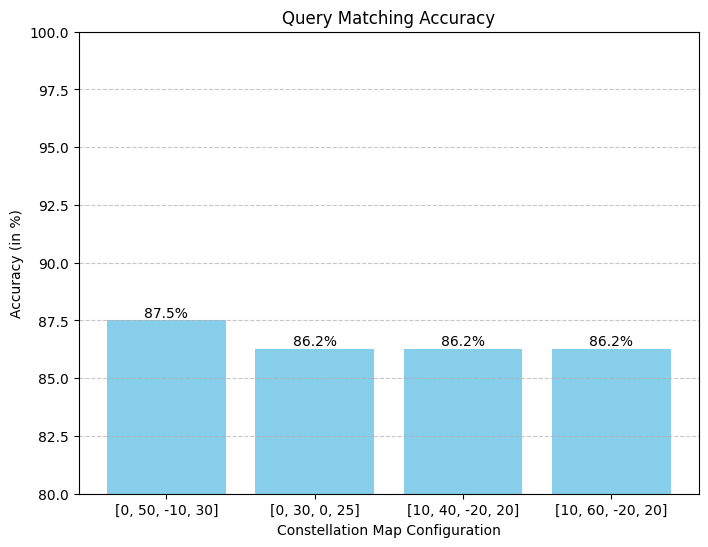

In [44]:
import matplotlib.pyplot as plt


accuracies = [get_accuracy(None, matches_1), get_accuracy(None, matches_2), get_accuracy(None, matches_2), get_accuracy(None, matches_2)]

# Values to plot
labels = [(f'[{config["time_min_offset"]}, {config["time_max_offset"]}, {config["freq_min_offset"]}, {config["freq_max_offset"]}]') for config in configs]
values = [ac*100 for ac in accuracies]


# Creating the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color='skyblue')

# Adding percentages above the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# Adding title and labels
plt.title('Query Matching Accuracy')
plt.xlabel('Constellation Map Configuration')
plt.ylabel('Accuracy (in %)')
plt.ylim(80, 100)  # Leave some space above the bars for annotations
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


## Category Comparison

# Thought process and Final Conclusion